# Importando as bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pymannkendall import original_test
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose
from db import connection_db as conndb
from db import filters
from utils.extracao_interacao import ExtracaoInteracao
from sklearn.metrics import davies_bouldin_score

from utils.text_treatment import TextTreatment
from tqdm.auto import tqdm

tqdm.pandas()

# Conectando ao banco de dados do MongoDB

Função para conectar ao MongoDB

In [ ]:
def conectar_mongodb(uri, db_name, collection_name):
    mongo_connection = conndb.MongoDBConnection(uri=uri, database_name=db_name, collection_name=collection_name)
    mongo_connection.connect()
    return mongo_connection.collection

In [ ]:
# Definindo os parâmetros de conexão
uri = 'mongodb://localhost:27017/'
db_name = 'dadosVivamente'
collection_name = 'dadosSemFiltros'
collection_name_filtered = 'dadosComFiltrosIniciais'

collection = conectar_mongodb(uri, db_name, collection_name)
collection_filtrada = conectar_mongodb(uri, db_name, collection_name_filtered)

# Aplicando pipeline para preparação dos dados

Função para aplicar os pipelines de filtro

In [ ]:
def aplicar_pipelines(collection, collection_filtrada):
    collection_filters = filters.CollectionFilters(collection)
    collection_filters_likes = filters.CollectionFilters(collection_filtrada)

    # Aplicar pipelines
    collection_filters.apply_pipeline1('dadosComFiltrosIniciais')
    # collection_filters.apply_pipeline2(7, 1, 'posts7anos1anos')
    collection_filters.apply_pipeline3('postsComBDIAndInfos')
    collection_filters.apply_pipeline4('posts')
    collection_filters_likes.apply_pipeline6('likes')

    return collection_filters.collection, collection_filters_likes.collection

In [ ]:
# Aplicando os pipelinesc
collection, collection_filtrada = aplicar_pipelines(collection, collection_filtrada)

# Carregando os dados em um dataframe

In [ ]:
documentos = collection.find()
df_post_original = pd.DataFrame(list(documentos))

# Visualizar as primeiras linhas do dataframe
df_post_original.head()

In [ ]:
documentos_likes = collection_filtrada.find()
df_original_likes = pd.DataFrame(list(documentos_likes))

# Visualizar as primeiras linhas do dataframe
df_original_likes.head()

In [ ]:
# Transformando a coluna sexo em binária
df_post_original['sexo'] = df_post_original['sexo'].map({'F': 0, 'M': 1})

# Removendo colunas desnecessárias
df_post_original.drop(columns=['_id', 'diaDaSemana'], inplace=True)

# Lista de colunas que precisam ser convertidas
colunas_para_converter = [
    'pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima', 'critica', 'suicida', 'choro',
    'agitacao', 'interesse', 'indecisao', 'desvalorizacao', 'energia', 'sono', 'irritabilidade', 'apetite',
    'concentracao', 'fadiga', 'int_sexo', 'quantAmigos'
]


# Função para preencher valores nulos e converter o tipo de dado
def preencher_e_converter(df, colunas, valor_preenchimento=0, tipo_dados='int64'):
    df[colunas] = df[colunas].fillna(valor_preenchimento)
    df[colunas] = df[colunas].astype(tipo_dados)
    return df

In [ ]:
df_post_original = preencher_e_converter(df_post_original, colunas_para_converter)

In [ ]:
# Remover usuarios que tem menos de 100 posts
df_post_original = df_post_original.groupby('id_usuario').filter(lambda value: len(value) >= 100)

In [ ]:
# Função para manipular datas e filtrar posts
def manipular_e_filtrar_posts(df):
    df['data'] = df['postCreatedTime'].dt.date
    df['data'] = pd.to_datetime(df['data'])
    df['mes'] = df['data'].dt.to_period('M')
    df['semana'] = df['data'].dt.to_period('W')

    df_data = df[df['data'].dt.year == 2017]
    df_data = df_data[~((df_data['data'].dt.month == 12) & (df_data['data'].dt.year == 2017))]
    df_data = df_data[df_data['data'].dt.month >= 5]
    df_data = df_data[df_data['suicida'] == 3]

    # Remover posts vazios
    df_data = df_data.dropna(subset=['postMessage', 'postStory'], how='all')
    df_data = df_data[~((df_data['postMessage'].str.strip() == '') & (df_data['postStory'].str.strip() == ''))]

    return df_data

In [ ]:
df_posts = manipular_e_filtrar_posts(df_post_original)

In [ ]:
# Remover usuarios que tem menos de 100 posts
df_posts = df_posts.groupby('id_usuario').filter(lambda value: len(value) >= 100)

df_posts.head()

In [ ]:
df_posts['id_usuario'].nunique()

In [ ]:
# Função para manipular datas e filtrar posts
def manipular_e_filtrar_likes(df):
    df['data'] = df['likeCreatedTime'].dt.date
    df['data'] = pd.to_datetime(df['data'])
    df['mes'] = df['data'].dt.to_period('M')
    df['semana'] = df['data'].dt.to_period('W')

    df_data = df[df['data'].dt.year == 2017]
    df_data = df_data[~((df_data['data'].dt.month == 12) & (df_data['data'].dt.year == 2017))]
    df_data = df_data[df_data['data'].dt.month >= 5]

    return df_data

In [ ]:
df_likes = manipular_e_filtrar_likes(df_original_likes)

# Pegar os mesmos usuários do df_posts
df_likes = df_likes[df_likes['id_usuario'].isin(df_posts['id_usuario'])]

# Adicionar a coluna de quantidade de likes
df_likes['quantLikes'] = df_likes['id_usuario'].apply(lambda value: 1 if pd.notnull(value) else 0)

df_likes.head()

# Adicionar interações do usuário

In [ ]:
df_posts['quantPostMsg'] = df_posts['postMessage'].apply(
    lambda value: 1 if pd.notnull(value) and value.strip() != '' else 0)

df_posts['quantPostStory'] = df_posts['postStory'].apply(
    lambda value: 1 if pd.notnull(value) and value.strip() != '' else 0)

df_posts['quantPosts'] = 1

In [ ]:
extracao = ExtracaoInteracao(df_posts)
df_posts_interacoes = extracao.extract_interactions()

df_posts_interacoes.head()

Função para calcular e visualizar a distribuição de postagens por usuário

In [ ]:
def plotar_histogramas_posts(df):
    fig, axs = plt.subplots(3, 1, figsize=(10, 8), dpi=300)

    # Quantidade geral de postagens
    quant_posts = df.groupby('id_usuario').size().reset_index(name='quant_posts')
    axs[0].hist(quant_posts['quant_posts'], bins=50)
    axs[0].set_xlabel('Quant de Posts')
    axs[0].set_ylabel('Quant de Usuários')

    # Quantidade de postagens com mensagem
    quant_msg = df.groupby('id_usuario')['quantPostMsg'].sum().reset_index(name='quant_msg')
    axs[1].hist(quant_msg['quant_msg'], bins=50)
    axs[1].set_xlabel('Quant de Posts com Mensagem')
    axs[1].set_ylabel('Quant de Usuários')

    # Quantidade de postagens com story
    quant_story = df.groupby('id_usuario')['quantPostStory'].sum().reset_index(name='quant_story')
    axs[2].hist(quant_story['quant_story'], bins=50)
    axs[2].set_xlabel('Quant de Posts com Story')
    axs[2].set_ylabel('Quant de Usuários')

    plt.tight_layout()
    plt.show()

In [ ]:
plotar_histogramas_posts(df_posts_interacoes)

In [ ]:
def plotar_histogramas_interacoes(df):
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), dpi=300)

    # Quantidade de atualização de Perfil
    quant_profile = df.groupby('id_usuario')['quantProfile'].sum().reset_index(name='quant_profile')
    axs[0, 0].hist(quant_profile['quant_profile'], bins=50)
    axs[0, 0].set_xlabel('Quant de Atualizações de Perfil')
    axs[0, 0].set_ylabel('Quant de Usuários')

    # Quantidade de atualização de Capa
    quant_cover = df.groupby('id_usuario')['quantCover'].sum().reset_index(name='quant_cover')
    axs[0, 1].hist(quant_cover['quant_cover'], bins=50)
    axs[0, 1].set_xlabel('Quant de Atualizações de Capa')
    axs[0, 1].set_ylabel('Quant de Usuários')

    # Quantidade de fotos com outras pessoas
    quant_photo_with_others = df.groupby('id_usuario')['quantAddPhotoWithOthers'].sum().reset_index(
        name='quant_photo_with_others')
    axs[1, 0].hist(quant_photo_with_others['quant_photo_with_others'], bins=50)
    axs[1, 0].set_xlabel('Quant de Fotos com Outras Pessoas')
    axs[1, 0].set_ylabel('Quant de Usuários')

    # Quantidade de está com outras pessoas
    quant_is_with_others = df.groupby('id_usuario')['quantIsWithOthers'].sum().reset_index(name='quant_is_with_others')
    axs[1, 1].hist(quant_is_with_others['quant_is_with_others'], bins=50)
    axs[1, 1].set_xlabel('Quant de Está com Outras Pessoas')
    axs[1, 1].set_ylabel('Quant de Usuários')

    # Quantidade de fotos adicionadas
    quant_add_photo = df.groupby('id_usuario')['quantAddPhoto'].sum().reset_index(name='quant_add_photo')
    axs[2, 0].hist(quant_add_photo['quant_add_photo'], bins=50)
    axs[2, 0].set_xlabel('Quant de Fotos Adicionadas')
    axs[2, 0].set_ylabel('Quant de Usuários')

    # Quantidade de fotos compartilhadas
    quant_shared_photo = df.groupby('id_usuario')['quantSharedPhoto'].sum().reset_index(name='quant_shared_photo')
    axs[2, 1].hist(quant_shared_photo['quant_shared_photo'], bins=50)
    axs[2, 1].set_xlabel('Quant de Fotos Compartilhadas')
    axs[2, 1].set_ylabel('Quant de Usuários')

    plt.tight_layout()
    plt.show()

In [ ]:
plotar_histogramas_interacoes(df_posts_interacoes)

In [ ]:
def plotar_histogramas_interacoes_2(df):
    fig, axs = plt.subplots(3, 2, figsize=(10, 8), dpi=300)

    # Quantidade de vídeos compartilhados
    quant_shared_video = df.groupby('id_usuario')['quantSharedVideo'].sum().reset_index(name='quant_shared_video')
    axs[0, 0].hist(quant_shared_video['quant_shared_video'], bins=50)
    axs[0, 0].set_xlabel('Quant de Vídeos Compartilhados')
    axs[0, 0].set_ylabel('Quant de Usuários')

    # Quantidade de links compartilhados
    quant_shared_link = df.groupby('id_usuario')['quantSharedLink'].sum().reset_index(name='quant_shared_link')
    axs[0, 1].hist(quant_shared_link['quant_shared_link'], bins=50)
    axs[0, 1].set_xlabel('Quant de Links Compartilhados')
    axs[0, 1].set_ylabel('Quant de Usuários')

    # Quantidade de posts compartilhados
    quant_shared_post = df.groupby('id_usuario')['quantSharedPost'].sum().reset_index(name='quant_shared_post')
    axs[1, 0].hist(quant_shared_post['quant_shared_post'], bins=50)
    axs[1, 0].set_xlabel('Quant de Posts Compartilhados')
    axs[1, 0].set_ylabel('Quant de Usuários')

    # Quantidade de eventos compartilhados
    quant_shared_event = df.groupby('id_usuario')['quantSharedEvent'].sum().reset_index(name='quant_shared_event')
    axs[1, 1].hist(quant_shared_event['quant_shared_event'], bins=50)
    axs[1, 1].set_xlabel('Quant de Eventos Compartilhados')
    axs[1, 1].set_ylabel('Quant de Usuários')

    # Quantidade de memórias compartilhadas
    quant_shared_memory = df.groupby('id_usuario')['quantSharedMemory'].sum().reset_index(name='quant_shared_memory')
    axs[2, 0].hist(quant_shared_memory['quant_shared_memory'], bins=50)
    axs[2, 0].set_xlabel('Quant de Memórias Compartilhadas')
    axs[2, 0].set_ylabel('Quant de Usuários')

    # Quantidade de status
    quant_status = df.groupby('id_usuario')['quantStatus'].sum().reset_index(name='quant_status')
    axs[2, 1].hist(quant_status['quant_status'], bins=50)
    axs[2, 1].set_xlabel('Quant de Atualizações de Status')
    axs[2, 1].set_ylabel('Quant de Usuários')

    plt.tight_layout()
    plt.show()

In [ ]:
plotar_histogramas_interacoes_2(df_posts_interacoes)

In [ ]:
df_posts_interacoes.head()

In [ ]:
df_agrupado_soma = df_posts_interacoes.groupby(['id_usuario']).agg(
    idade=('idade', 'first'),
    sexo=('sexo', 'first'),
    quantAmigos=('quantAmigos', 'first'),
    quantPosts=('quantPosts', 'sum'),
    quantPostMsg=('quantPostMsg', 'sum'),
    somaProfile=('quantProfile', 'sum'),
    somaCover=('quantCover', 'sum'),
    somaStatus=('quantStatus', 'sum'),
    somaAddPhotoWithOthers=('quantAddPhotoWithOthers', 'sum'),
    somaIsWithOthers=('quantIsWithOthers', 'sum'),
    somaAddPhoto=('quantAddPhoto', 'sum'),
    somaSharedPhoto=('quantSharedPhoto', 'sum'),
    somaSharedVideo=('quantSharedVideo', 'sum'),
    somaSharedLink=('quantSharedLink', 'sum'),
    somaSharedPost=('quantSharedPost', 'sum'),
    somaSharedEvent=('quantSharedEvent', 'sum'),
    somaSharedMemory=('quantSharedMemory', 'sum'),
    pessimismo=('pessimismo', 'first'),
    tristeza=('tristeza', 'first'),
    fracasso=('fracasso', 'first'),
    prazer=('prazer', 'first'),
    culpa=('culpa', 'first'),
    punicao=('punicao', 'first'),
    estima=('estima', 'first'),
    critica=('critica', 'first'),
    suicida=('suicida', 'first'),
    choro=('choro', 'first'),
    agitacao=('agitacao', 'first'),
    interesse=('interesse', 'first'),
    indecisao=('indecisao', 'first'),
    desvalorizacao=('desvalorizacao', 'first'),
    energia=('energia', 'first'),
    sono=('sono', 'first'),
    irritabilidade=('irritabilidade', 'first'),
    apetite=('apetite', 'first'),
    concentracao=('concentracao', 'first'),
    fadiga=('fadiga', 'first'),
    int_sexo=('int_sexo', 'first'),
).reset_index()

In [ ]:
df_likes_agrupado = df_likes.groupby('id_usuario').agg(
    somaLikes=('quantLikes', 'sum')
)

# Juntar os dataframes
df_agrupado_soma = df_agrupado_soma.merge(df_likes_agrupado, on='id_usuario', how='left')

# Preencher valores NaN com 0
df_agrupado_soma.fillna(0, inplace=True)

In [ ]:
# Criar uma matriz de correlação para as interações
colunas_interacoes = df_agrupado_soma[[
    'quantPostMsg', 'somaProfile', 'somaCover', 'somaAddPhotoWithOthers', 'somaIsWithOthers', 'somaAddPhoto',
    'somaSharedPhoto', 'somaSharedVideo', 'somaSharedLink', 'somaSharedPost', 'somaSharedEvent', 'somaSharedMemory',
    'somaStatus', 'somaLikes'
]]

matriz_correlacao = colunas_interacoes.corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [ ]:
from scipy.stats import spearmanr

# Testar para todas as combinações de variáveis
for i in range(len(colunas_interacoes.columns)):
    for j in range(i + 1, len(colunas_interacoes.columns)):
        x = colunas_interacoes.iloc[:, i]
        y = colunas_interacoes.iloc[:, j]

        spearman_corr, p_value = spearmanr(x, y)
        print(
            f'Correlação de Spearman entre {colunas_interacoes.columns[i]} e {colunas_interacoes.columns[j]}: {spearman_corr}')
        print(f'P-valor de Spearman: {p_value}')

In [ ]:
df_agrupado_soma['mediaInteracoesComOutros'] = df_agrupado_soma[[
    'somaAddPhotoWithOthers', 'somaIsWithOthers'
]].mean(axis=1).round(2)

df_agrupado_soma['mediaAtualizacaoPerfil'] = df_agrupado_soma[[
    'somaProfile', 'somaCover'
]].mean(axis=1).round(2)

df_agrupado_soma['mediaSharedPhotoPost'] = df_agrupado_soma[[
    'somaSharedPhoto', 'somaSharedPost'
]].mean(axis=1).round(2)

# Dropar as colunas originais
df_agrupado_soma.drop(columns=[
    'somaProfile', 'somaCover', 'somaAddPhotoWithOthers', 'somaIsWithOthers', 'somaSharedPhoto', 'somaSharedPost'
], inplace=True)

In [ ]:
# Criar uma matriz de correlação para as respostas do BDI
colunas_respostas = df_agrupado_soma[[
    'pessimismo', 'tristeza', 'fracasso', 'prazer', 'culpa', 'punicao', 'estima', 'critica', 'choro',
    'agitacao', 'interesse', 'indecisao', 'desvalorizacao', 'energia', 'sono', 'irritabilidade', 'apetite',
    'concentracao', 'fadiga', 'int_sexo', 'idade', 'sexo', 'quantAmigos'
]]

matriz_correlacao_respostas = colunas_respostas.corr(method='spearman')

plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlacao_respostas, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# Testar para todas as combinações de variáveis
for i in range(len(colunas_respostas.columns)):
    for j in range(i + 1, len(colunas_respostas.columns)):
        x = colunas_respostas.iloc[:, i]
        y = colunas_respostas.iloc[:, j]

        spearman_corr, p_value = spearmanr(x, y)
        print(
            f'Correlação de Spearman entre {colunas_respostas.columns[i]} e {colunas_respostas.columns[j]}: {spearman_corr}')
        print(f'P-valor de Spearman: {p_value}')

In [ ]:
variaveis = df_agrupado_soma[[
    'quantPosts'
]]

In [ ]:
k_values = range(2, 11)
silhouette_scores = []
davies_bouldin_scores = []
inertias = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(variaveis)
    inertias.append(kmeans.inertia_)

    # Obter os rótulos dos clusters
    labels = kmeans.labels_

    # Calcular o Coeficiente de Silhueta
    silhouette_avg = silhouette_score(variaveis, labels)
    silhouette_scores.append(silhouette_avg)

    # Calcular o Índice de Davies-Bouldin
    db_index = davies_bouldin_score(variaveis, labels)
    davies_bouldin_scores.append(db_index)

In [ ]:
# Plotar as métricas em um único gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico da Inércia
color_inertia = 'tab:blue'
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inércia', color=color_inertia)
ax1.plot(k_values, inertias, marker='o', color=color_inertia, label='Inércia')
ax1.tick_params(axis='y', labelcolor=color_inertia)
ax1.set_xticks(k_values)

ax2 = ax1.twinx()

color_silhouette = 'tab:green'
color_db = 'tab:red'
ax2.set_ylabel('Métricas', color='black')
ax2.plot(k_values, silhouette_scores, marker='s', color=color_silhouette, label='Coeficiente de Silhueta')
ax2.plot(k_values, davies_bouldin_scores, marker='^', color=color_db, label='Índice de Davies-Bouldin')
ax2.tick_params(axis='y', labelcolor='black')

# Combinar as legendas
lines_labels = [ax1.get_legend_handles_labels(), ax2.get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax2.legend(lines, labels, loc='upper right')

# Título do Gráfico
# plt.title('Avaliação do K-Means com Inércia, Coeficiente de Silhueta e Índice de Davies-Bouldin')

plt.show()

In [ ]:
# Printar o silhouette score junto com o número de clusters
for k, score in zip(k_values, silhouette_scores):
    print(f'Número de Clusters: {k} - Coeficiente de Silhueta: {score}')

print('\n')

# Printar o índice de Davies-Bouldin junto com o número de clusters
for k, score in zip(k_values, davies_bouldin_scores):
    print(f'Número de Clusters: {k} - Índice de Davies-Bouldin: {score}')

# Printar a inércia junto com o número de clusters
for k, score in zip(k_values, inertias):
    print(f'Número de Clusters: {k} - Inércia: {score}')

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(variaveis)

df_agrupado_soma['cluster'] = kmeans.labels_

print(df_agrupado_soma[['id_usuario', 'cluster']].head())

In [ ]:
df_agrupado_soma.to_csv('df_agrupado_soma.csv', index=False)
df_agrupado_soma['cluster'].value_counts()

In [ ]:
def teste_mk(df_cluster, periodo, tipo_serie='posts'):
    resultados_mk = []

    for usuario in df_cluster['id_usuario'].unique():
        df_usuario = df_cluster[df_cluster['id_usuario'] == usuario]

        eventos_por_dia = df_usuario.groupby('data').size()

        if len(eventos_por_dia) >= 2 * periodo:
            try:
                resultado = seasonal_decompose(eventos_por_dia, model='additive', period=periodo)
                tendencia = resultado.trend.dropna()

                if len(tendencia) > 0:
                    result = original_test(tendencia)

                    if hasattr(result, 'trend'):
                        resultados_mk.append({
                            'id_usuario': usuario,
                            'trend': result.trend,
                            'h': result.h,
                            'p-valor': result.p,
                            'z': result.z,
                            'Tau': result.Tau,
                            'slope': result.slope,
                        })
                    else:
                        print(f"Usuário {usuario} - Resultado do teste de Mann-Kendall sem 'trend'.")
                else:
                    print(f"Usuário {usuario} - Não foi possível decompor dados suficientes para tendência.")
            except ValueError as e:
                print(f"Erro ao decompor a série para o usuário {usuario}: {e}")
        else:
            print(
                f"Usuário {usuario} não tem observações suficientes para decomposição. Necessário: {2 * periodo}, disponível: {len(eventos_por_dia)}")

    # Criando o DataFrame apenas se houver resultados suficientes
    if resultados_mk:
        df_resultados_mk = pd.DataFrame(resultados_mk)

        if 'trend' in df_resultados_mk.columns:
            contagem_tendencias = df_resultados_mk['trend'].value_counts()
            print(contagem_tendencias)

            total_usuarios = df_resultados_mk.shape[0]
            percentuais = (contagem_tendencias / total_usuarios) * 100
            print(percentuais)

            # Gráfico de barras das tendências
            plt.figure(figsize=(8, 6))
            sns.countplot(data=df_resultados_mk, x='trend', order=['increasing', 'decreasing', 'no trend'])
            plt.title(f'Distribuição de Tendências entre Usuários ({tipo_serie.capitalize()})')
            plt.xlabel('Tipo de Tendência')
            plt.ylabel('Número de Usuários')
            plt.show()

            # Gráfico de distribuição dos slopes
            plt.figure(figsize=(10, 6))
            sns.histplot(df_resultados_mk['slope'], bins=20, kde=True)
            plt.title(f'Distribuição dos Slopes entre Usuários ({tipo_serie.capitalize()})')
            plt.xlabel('Slope')
            plt.ylabel('Frequência')
            plt.show()

        else:
            print("Nenhuma tendência foi detectada nos dados.")

        return df_resultados_mk
    else:
        print("Nenhum dado disponível para análise.")
        return pd.DataFrame()

In [ ]:
df_agrupado_soma.head()

In [ ]:
# buscar no dataframe df_posts_interacoes os usuários do cluster 0, 1 e 2
df_cluster0_soma = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(df_agrupado_soma[df_agrupado_soma['cluster'] == 0]['id_usuario'])]
df_cluster0_soma.to_csv('df_cluster0_soma.csv', index=False)

df_cluster1_soma = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(df_agrupado_soma[df_agrupado_soma['cluster'] == 1]['id_usuario'])]
df_cluster1_soma.to_csv('df_cluster1_soma.csv', index=False)

df_cluster2_soma = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(df_agrupado_soma[df_agrupado_soma['cluster'] == 2]['id_usuario'])]
df_cluster2_soma.to_csv('df_cluster2_soma.csv', index=False)

df_cluster = pd.concat([df_cluster0_soma, df_cluster1_soma, df_cluster2_soma])
df_cluster.to_csv('df_cluster.csv', index=False)

In [ ]:
resultados_mk_cluster0 = teste_mk(df_cluster0_soma, 30)
resultados_mk_cluster1 = teste_mk(df_cluster1_soma, 30)
resultados_mk_cluster2 = teste_mk(df_cluster2_soma, 30)
resultados_mk = pd.concat([resultados_mk_cluster0, resultados_mk_cluster1, resultados_mk_cluster2])

# Salvar o resultado em um arquivo CSV
resultados_mk_cluster0.to_csv('resultados_mk_cluster0.csv', index=False)
resultados_mk_cluster1.to_csv('resultados_mk_cluster1.csv', index=False)
resultados_mk_cluster2.to_csv('resultados_mk_cluster2.csv', index=False)
resultados_mk.to_csv('resultados_mk.csv', index=False)

In [ ]:
df_usuarios_cluster = df_agrupado_soma[df_agrupado_soma['id_usuario'].isin(resultados_mk['id_usuario'])]

df_usuarios_cluster.to_csv('df_usuarios_cluster.csv', index=False)
df_usuarios_cluster.head()

In [ ]:
tratamento_texto = TextTreatment()

df_posts_interacoes['postMessageLimpo'] = df_posts_interacoes['postMessage'].fillna('').progress_apply(
    lambda texto: tratamento_texto.preprocessamento_texto(texto) if texto else '')

df_posts_interacoes[['postMessage', 'postMessageLimpo']].head()

In [ ]:
df_posts_interacoes.to_csv('df_posts.csv', index=False)

In [ ]:
from utils.text_vectorization import TextVectorization
from utils.nuvem_palavras import NuvemPalavras

df_cluster0 = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(df_usuarios_cluster[df_usuarios_cluster['cluster'] == 0]['id_usuario'])]

df_cluster0.to_csv('df_cluster0.csv', index=False)

df_cluster1 = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(df_usuarios_cluster[df_usuarios_cluster['cluster'] == 1]['id_usuario'])]

df_cluster1.to_csv('df_cluster1.csv', index=False)

df_cluster2 = df_posts_interacoes[
    df_posts_interacoes['id_usuario'].isin(df_usuarios_cluster[df_usuarios_cluster['cluster'] == 2]['id_usuario'])]

df_cluster2.to_csv('df_cluster2.csv', index=False)

           id_usuario   palavra  contagem
0    1457411227699416      vida        14
1    1457411227699416     mundo        11
2    1457411227699416      amor        11
3    1457411227699416       gay        10
4    1457411227699416       top        10
..                ...       ...       ...
245  1942377509357721     mundo         7
246  1942377509357721       dor         7
247  1942377509357721  aguentar         6
248  1942377509357721  tatuagem         6
249  1942377509357721      vida         6

[250 rows x 3 columns]


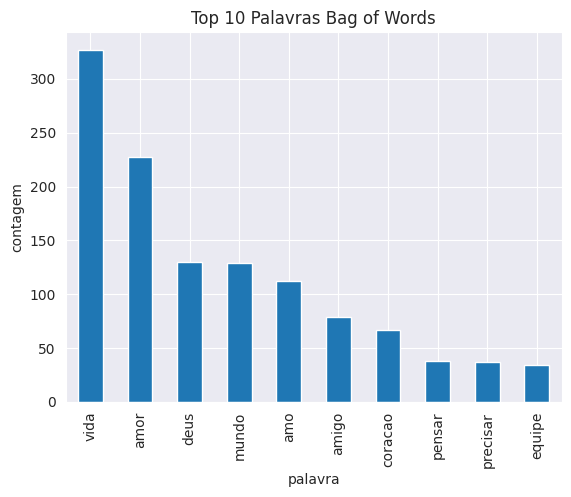

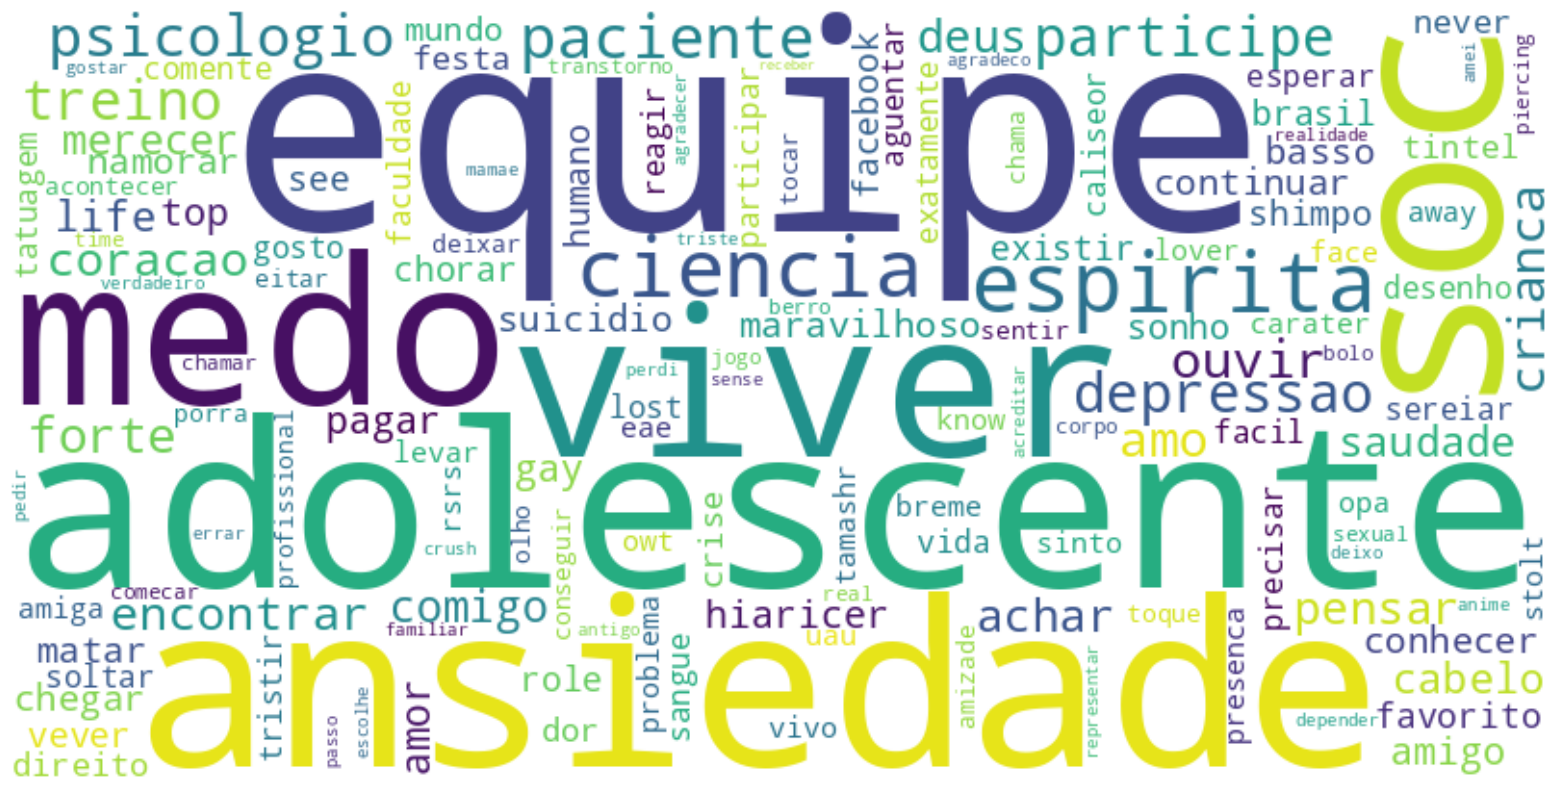

In [55]:
# Carregar stopwords para o Bag of Words
stop_words = tratamento_texto.get_stopwords()
text_vectorizer_cluster0 = TextVectorization(df_cluster0, stop_words)

# Vetorização Bag of Words
resultados_bow_cluster0 = text_vectorizer_cluster0.bag_of_words_vectorization('bow_cluster0.csv', 0.85, 5, (1, 1))

text_vectorizer_cluster0.plot_top_words(resultados_bow_cluster0, column='contagem', title='Top 10 Palavras Bag of Words')

frequencias_bow_cluster0 = dict(zip(resultados_bow_cluster0['palavra'], resultados_bow_cluster0['contagem']))

# Gerar e plotar a nuvem de palavras
NuvemPalavras.plot_nuvem_palavras(frequencias_bow_cluster0)

         id_usuario      palavra  contagem
0   741112402763818        amigo        10
1   741112402763818      coracao         9
2   741112402763818       pensar         9
3   741112402763818        mundo         8
4   741112402763818          amo         7
..              ...          ...       ...
95  928018567367487  brincadeira         2
96  928018567367487       chegar         2
97  928018567367487         vida         2
98  928018567367487        levar         2
99  928018567367487      celular         2

[100 rows x 3 columns]


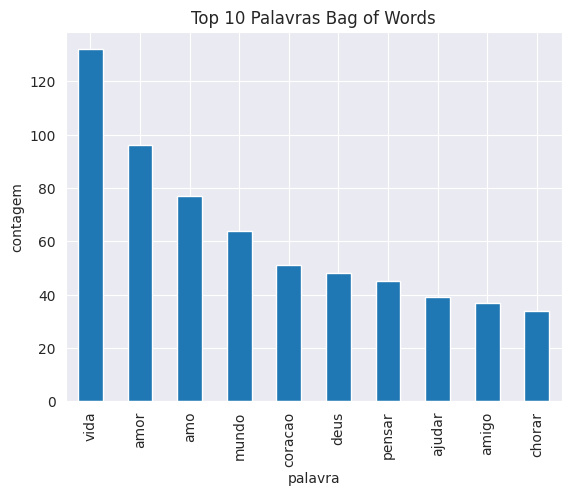

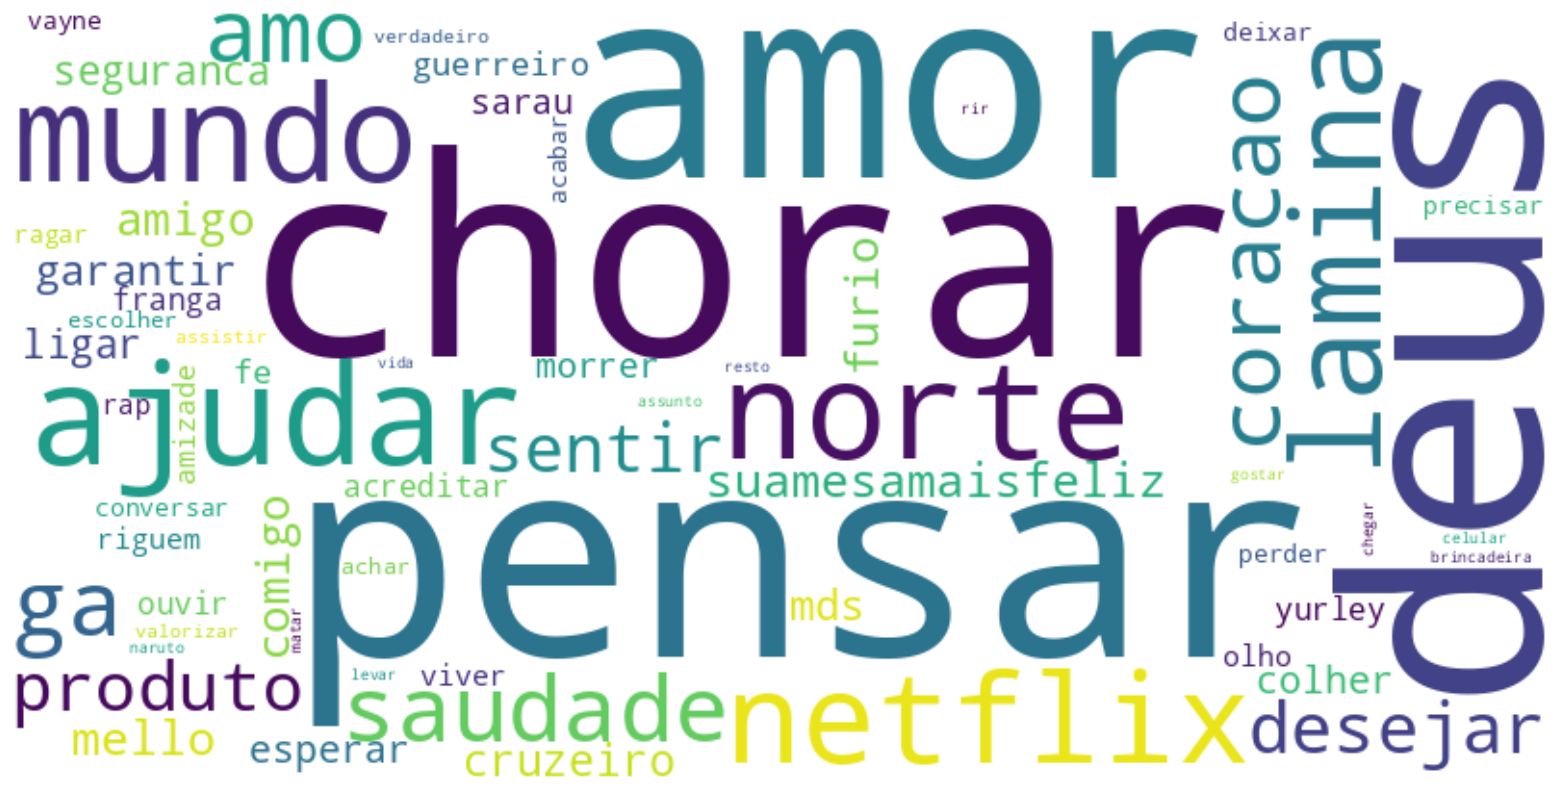

In [53]:
text_vectorizer_cluster1 = TextVectorization(df_cluster1, stop_words)

# Vetorização Bag of Words
resultados_bow_cluster1 = text_vectorizer_cluster1.bag_of_words_vectorization('bow_cluster1.csv', 0.85, 5, (1, 1))

text_vectorizer_cluster1.plot_top_words(resultados_bow_cluster1, column='contagem', title='Top 10 Palavras Bag of Words')

frequencias_bow_cluster1 = dict(zip(resultados_bow_cluster1['palavra'], resultados_bow_cluster1['contagem']))

# Gerar e plotar a nuvem de palavras
NuvemPalavras.plot_nuvem_palavras(frequencias_bow_cluster1)

           id_usuario   palavra  contagem
0    1492157617538982   youtube        11
1    1492157617538982     watch        11
2    1492157617538982    brasil         2
3    1492157617538982  familiar         2
4    1492157617538982   crianco         2
..                ...       ...       ...
245  1211223432346372      fofo         2
246  1211223432346372  presente         2
247  1211223432346372     aluno         2
248  1211223432346372      vida         2
249  1211223432346372   negocio         2

[250 rows x 3 columns]


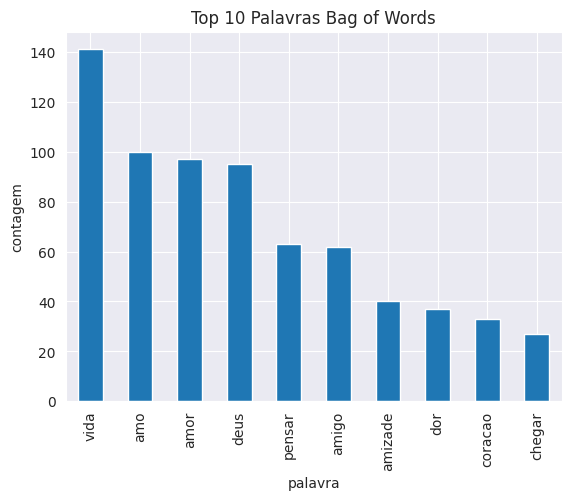

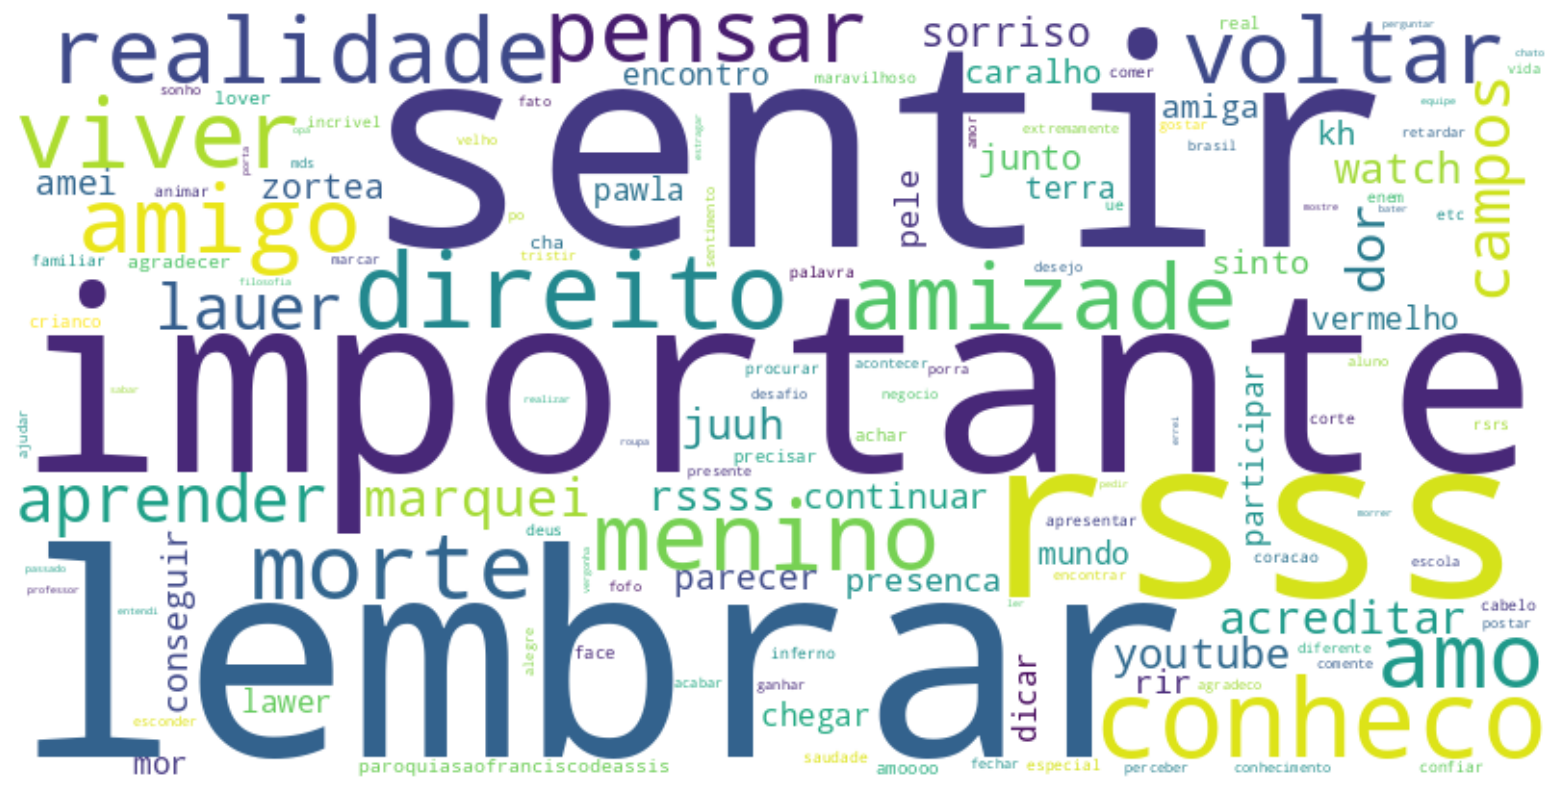

In [54]:
text_vectorizer_cluster2 = TextVectorization(df_cluster2, stop_words)

# Vetorização Bag of Words
resultados_bow_cluster2 = text_vectorizer_cluster2.bag_of_words_vectorization('bow_cluster2.csv', 0.85, 5, (1, 1))

text_vectorizer_cluster2.plot_top_words(resultados_bow_cluster2, column='contagem', title='Top 10 Palavras Bag of Words')

frequencias_bow_cluster2 = dict(zip(resultados_bow_cluster2['palavra'], resultados_bow_cluster2['contagem']))

# Gerar e plotar a nuvem de palavras
NuvemPalavras.plot_nuvem_palavras(frequencias_bow_cluster2)